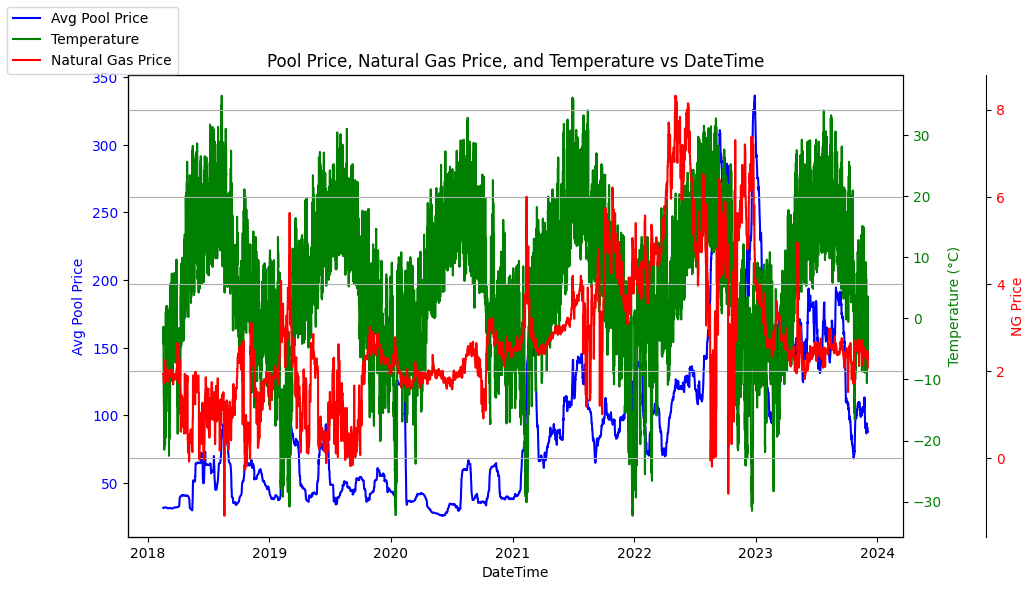

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
data = pd.read_csv('Calgary_merged_expanded_data_with_generator.csv', parse_dates=['DateTime'])

# Create a single plot with separate y-axes for temperature and NG price
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Pool Price
ax1.plot(data['DateTime'], data['rolling_30day_avg'], label='Avg Pool Price', color='blue')
ax1.set_xlabel('DateTime')
ax1.set_ylabel('Avg Pool Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the temperature
ax2 = ax1.twinx()
ax2.plot(data['DateTime'], data['Temp (°C)'], label='Temperature', color='green')
ax2.set_ylabel('Temperature (°C)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Create a third y-axis for the NG price
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the right spine of ax3
ax3.plot(data['DateTime'], data['NG_price'], label='Natural Gas Price', color='red')
ax3.set_ylabel('NG Price', color='red')
ax3.tick_params(axis='y', labelcolor='red')

# Add a legend with custom handles
handles, labels = [], []
for ax in [ax1, ax2, ax3]:
    for h, l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)
fig.legend(handles, labels, loc='upper left')

plt.title("Pool Price, Natural Gas Price, and Temperature vs DateTime")
plt.grid(True)
plt.show()

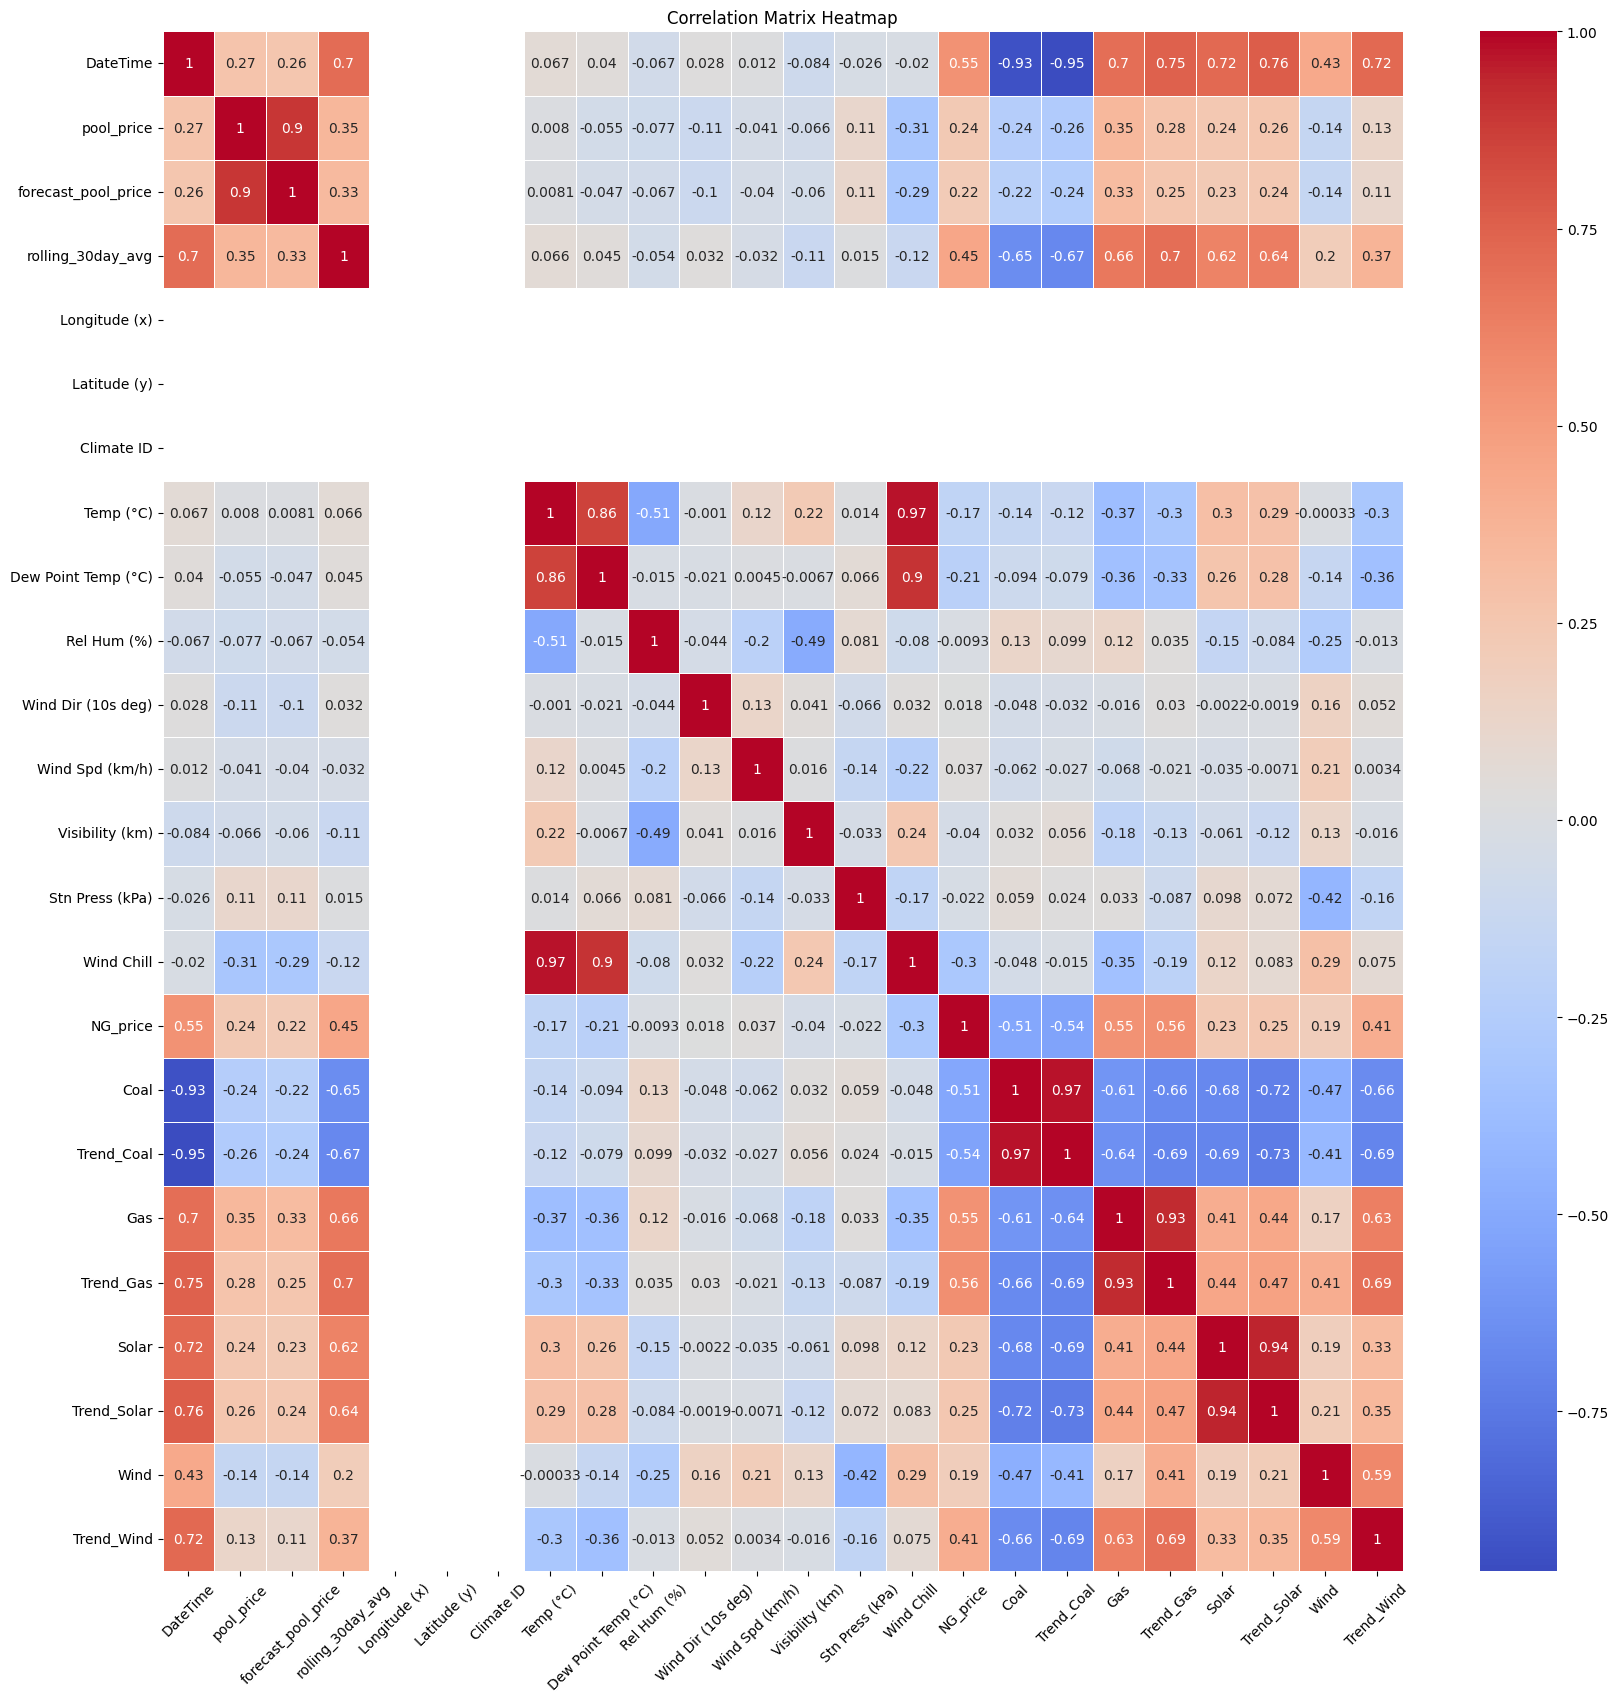

In [4]:
correlation_matrix = data.corr()

# Create a heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Customize the plot (optional)
plt.title("Correlation Matrix Heatmap")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [5]:
data.head()

,DateTime,pool_price,forecast_pool_price,rolling_30day_avg,Longitude (x),Latitude (y),Climate ID,Temp (°C),Dew Point Temp (°C),Rel Hum (%),...,Wind Chill,NG_price,Coal,Trend_Coal,Gas,Trend_Gas,Solar,Trend_Solar,Wind,Trend_Wind
0,2018-02-16 00:00:00,22.10,20.58,31.73,-114.01,51.12,3031092,-2.3,-17.9,30.0,...,-11.0,1.9434,76206.83603,82201.93117,123494.2905,131891.2669,52.723999,2.631894,19336.487,12246.76825
1,2018-02-16 01:00:00,22.67,19.01,31.72,-114.01,51.12,3031092,-2.4,-16.4,34.0,...,-9.0,1.9434,76206.83603,82201.93117,123494.2905,131891.2669,52.723999,2.631894,19336.487,12246.76825
2,2018-02-16 02:00:00,23.39,23.15,31.72,-114.01,51.12,3031092,-2.5,-16.5,34.0,...,-10.0,1.9434,76206.83603,82201.93117,123494.2905,131891.2669,52.723999,2.631894,19336.487,12246.76825
3,2018-02-16 03:00:00,23.60,25.29,31.71,-114.01,51.12,3031092,-3.0,-15.9,37.0,...,-11.0,1.9434,76206.83603,82201.93117,123494.2905,131891.2669,52.723999,2.631894,19336.487,12246.76825
4,2018-02-16 04:00:00,24.34,26.16,31.71,-114.01,51.12,3031092,-2.9,-15.8,37.0,...,-10.0,1.9434,76206.83603,82201.93117,123494.2905,131891.2669,52.723999,2.631894,19336.487,12246.76825


Mean Squared Error: 17555.36297587755
R-squared: 0.19766323666317231


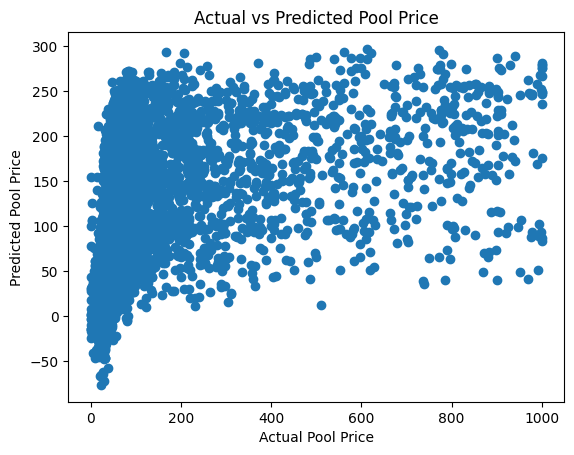

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score  # Importing the mean_squared_error function
from sklearn.impute import SimpleImputer


# Replace NaN values with zeros in production data
data = data.fillna(0)

# Preparing the data for modeling
X = data[['Temp (°C)', 'NG_price', 'Coal', 'Gas', 'Solar', 'Wind']]  # independent variables
y = data['pool_price']  # dependent variable

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Creating the model
model = LinearRegression()

# Training the model
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plotting the results
# Here we plot the predicted pool_price vs actual pool_price
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Pool Price')
plt.ylabel('Predicted Pool Price')
plt.title('Actual vs Predicted Pool Price')
plt.show()


Random Forest Mean Squared Error: 10222.512469894515
Random Forest R-squared: 0.5327981779963434


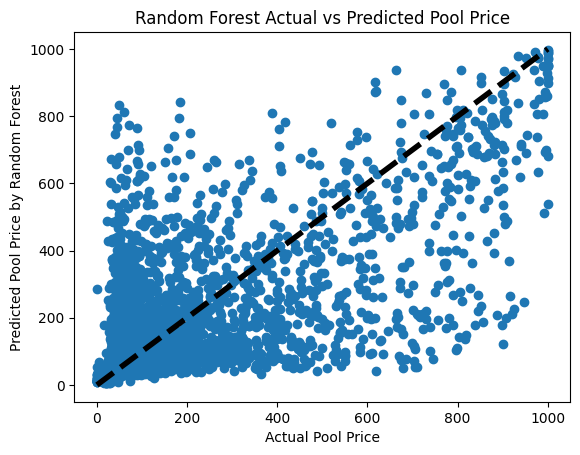

In [11]:
from sklearn.ensemble import RandomForestRegressor

# Handling NaN values using SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_imputed = imputer.fit_transform(data[['Temp (°C)', 'NG_price', 'Coal', 'Gas', 'Solar', 'Wind']])

# Preparing the data for modeling
X = pd.DataFrame(X_imputed, columns=['Temp (°C)', 'NG_price', 'Coal', 'Gas', 'Solar', 'Wind'])  # independent variables
y = data['pool_price'].dropna()  # dependent variable

# Ensure that the index aligns between X and y after dropping NaN values
X = X.loc[y.index]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Creating the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)

# Training the model
rf_model.fit(X_train, y_train)

# Making predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluating the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Random Forest Mean Squared Error: {mse_rf}')
print(f'Random Forest R-squared: {r2_rf}')

# Plotting the results
plt.scatter(y_test, y_pred_rf)
plt.xlabel('Actual Pool Price')
plt.ylabel('Predicted Pool Price by Random Forest')
plt.title('Random Forest Actual vs Predicted Pool Price')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
plt.show()

In [9]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Assuming 'data' is your DataFrame and it has been loaded correctly.

# Handling NaN values using SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_imputed = imputer.fit_transform(data[['Temp (°C)', 'NG_price', 'Coal', 'Gas', 'Solar', 'Wind']])

# Preparing the data for modeling
X = pd.DataFrame(X_imputed, columns=['Temp (°C)', 'NG_price', 'Coal', 'Gas', 'Solar', 'Wind'])  # independent variables
y = data['pool_price'].dropna()  # dependent variable

# Ensure that the index aligns between X and y after dropping NaN values
X = X.loc[y.index]

# Standardizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

# Creating the neural network model
model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))  # Input layer and first hidden layer
model.add(Dense(5, activation='relu'))  # Second hidden layer
model.add(Dense(1, activation='linear'))  # Output layer

# Compiling the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Training the model
model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=1)

# Making predictions
y_pred_nn = model.predict(X_test)

# Evaluating the model
mse_nn = mean_squared_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)

print(f'Neural Network Mean Squared Error: {mse_nn}')
print(f'Neural Network R-squared: {r2_nn}')


Epoch 1/100


c:\Users\gaoqian\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4065/4065 ━━━━━━━━━━━━━━━━━━━━ 2s 495us/step - loss: 23826.7109
Epoch 2/100
4065/4065 ━━━━━━━━━━━━━━━━━━━━ 2s 368us/step - loss: 17517.0586
Epoch 3/100
4065/4065 ━━━━━━━━━━━━━━━━━━━━ 2s 376us/step - loss: 17357.8965
Epoch 4/100
4065/4065 ━━━━━━━━━━━━━━━━━━━━ 2s 370us/step - loss: 16387.4258
Epoch 5/100
4065/4065 ━━━━━━━━━━━━━━━━━━━━ 2s 369us/step - loss: 15607.3955
Epoch 6/100
4065/4065 ━━━━━━━━━━━━━━━━━━━━ 2s 372us/step - loss: 15336.6416
Epoch 7/100
4065/4065 ━━━━━━━━━━━━━━━━━━━━ 2s 368us/step - loss: 15822.4941
Epoch 8/100
4065/4065 ━━━━━━━━━━━━━━━━━━━━ 2s 366us/step - loss: 15702.9209
Epoch 9/100
4065/4065 ━━━━━━━━━━━━━━━━━━━━ 2s 382us/step - loss: 15544.8193
Epoch 10/100
4065/4065 ━━━━━━━━━━━━━━━━━━━━ 1s 356us/step - loss: 15913.1211
Epoch 11/100
4065/4065 ━━━━━━━━━━━━━━━━━━━━ 2s 381us/step - loss: 15234.6475
Epoch 12/100
4065/4065 ━━━━━━━━━━━━━━━━━━━━ 2s 380us/step - loss: 14755.6738
Epoch 13/100
4065/4065 ━━━━━━━━━━━━━━━━━━━━ 2s 376us/step - loss: 15117.2197
Epoch 14/100
4065/40

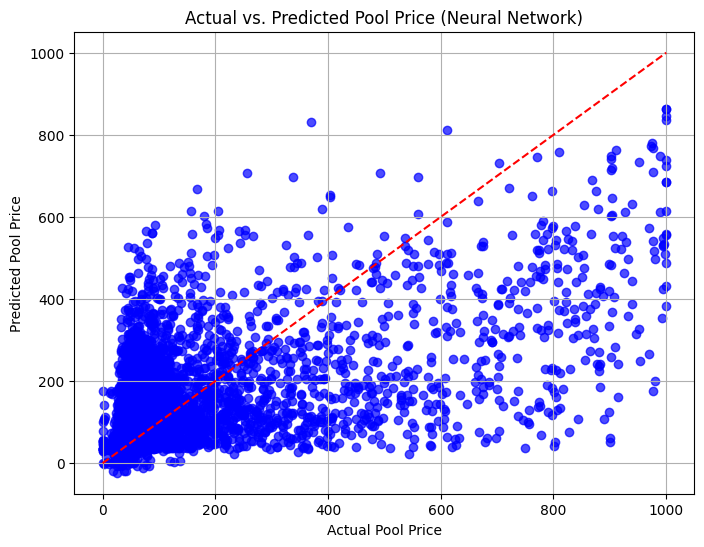

In [10]:
# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_nn, color='b', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', linestyle='--')
plt.xlabel('Actual Pool Price')
plt.ylabel('Predicted Pool Price')
plt.title('Actual vs. Predicted Pool Price (Neural Network)')
plt.grid(True)
plt.show()